# Clustering

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn import mixture

In [2]:
# Load the PCA-transformed data
pca_df = pd.read_pickle('../data/pca_df.pkl')
pca_df.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,timestamp
0,-0.486093,-0.158049,-0.186432,-0.008248,0.336819,0.013108,-0.034847,-0.113593,0.054178
1,0.262609,0.378496,0.429960,0.149426,0.054246,-0.078464,-0.104022,0.011744,0.910510
2,0.008030,-0.234484,-0.428483,-0.115379,0.139530,-0.090999,-0.013137,0.022662,0.117655
3,0.396516,0.107089,-0.262947,-0.081122,0.031191,-0.115548,-0.166672,0.049578,0.696197
4,-0.321760,-0.168364,0.277331,-0.054088,0.117170,0.061274,-0.053198,0.112418,0.101598


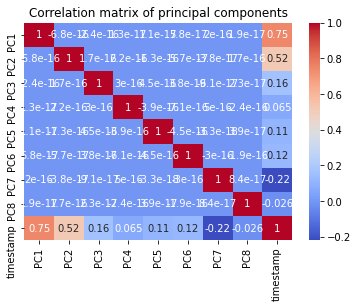

In [3]:
# Plot correlation matrix of principal components
corr_matrix = pca_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation matrix of principal components')
plt.show()

### KMeans

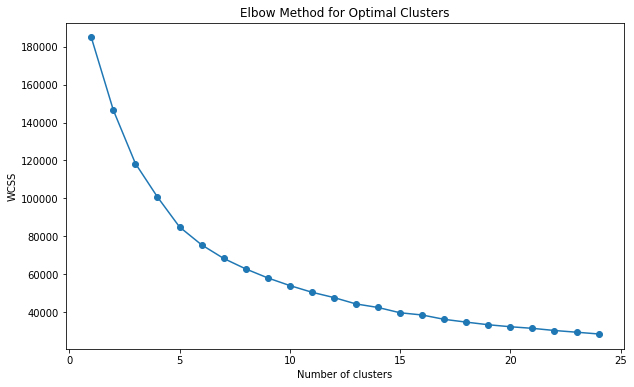

In [10]:
# Determine the optimal number of clusters using the Elbow Method
wcss = []  # Within-cluster sum of squares
for i in range(1, 25):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(pca_df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 25), wcss, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [18]:
# Helper function to get Betweenss (inter-cluster distance)
def get_betweenss(cluster_model):
    betweenss = 0
    overall_mean = np.mean(pca_df, axis=0)
    for i in range(cluster_model.n_clusters):
        cluster_points = pca_df[cluster_model.labels_ == i]
        cluster_mean = np.mean(cluster_points, axis=0)
        cluster_size = len(cluster_points)
        betweenss += cluster_size * np.sum((cluster_mean - overall_mean) ** 2)
    return betweenss


In [19]:
# Calculate cohesion (the lower the better) and separation (the higher the better)
def get_cohesion_and_separation(cluster_model):
    betweenss = get_betweenss(cluster_model)
    withinss = cluster_model.inertia_
    return [withinss/(betweenss + withinss), betweenss/(betweenss + withinss)]

In [20]:
# Allow model comparison with different K values
def compare_models(k_list):
    model_list = []
    for k in k_list:
        kmeans = KMeans(n_clusters=k, random_state=42).fit(pca_df)
        cohesion, separation = get_cohesion_and_separation(kmeans)
        print(f"K = {k}, Cohesion = {round(cohesion, 3)}, Separation = {round(separation, 3)}")
        model_list.append(kmeans)
    return model_list

compare_models([5, 10, 15, 20, 25, 30])


K = 5, Cohesion = 0.661, Separation = 0.339
K = 10, Cohesion = 0.535, Separation = 0.465
K = 15, Cohesion = 0.469, Separation = 0.531
K = 20, Cohesion = 0.418, Separation = 0.582
K = 25, Cohesion = 0.386, Separation = 0.614
K = 30, Cohesion = 0.359, Separation = 0.641


[KMeans(n_clusters=5, random_state=42),
 KMeans(n_clusters=10, random_state=42),
 KMeans(n_clusters=15, random_state=42),
 KMeans(n_clusters=20, random_state=42),
 KMeans(n_clusters=25, random_state=42),
 KMeans(n_clusters=30, random_state=42)]

In [17]:
# Get baseline model and labeled data
kmeans = KMeans(n_clusters=4, random_state=42).fit(pca_df)
kmeans_labeled = pca_df.assign(label=kmeans.labels_)
kmeans_labeled.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,timestamp,label
0,-0.486093,-0.158049,-0.186432,-0.008248,0.336819,0.013108,-0.034847,-0.113593,0.054178,1
1,0.262609,0.378496,0.429960,0.149426,0.054246,-0.078464,-0.104022,0.011744,0.910510,2
2,0.008030,-0.234484,-0.428483,-0.115379,0.139530,-0.090999,-0.013137,0.022662,0.117655,3
3,0.396516,0.107089,-0.262947,-0.081122,0.031191,-0.115548,-0.166672,0.049578,0.696197,0
4,-0.321760,-0.168364,0.277331,-0.054088,0.117170,0.061274,-0.053198,0.112418,0.101598,3


### GMM

In [4]:
gmm = mixture.GaussianMixture(n_components=4, covariance_type='full', n_init=100).fit(pca_df)
gmm_labeled = pca_df.assign(label=gmm.predict(pca_df))
gmm_labeled.head(5)
print(f"The random state of the model is {gmm.random_state}")

The random state of the model is None


### Baseline Model Kaggle Submission

In [17]:
# Reorder the laebl and format output for kaggle submission
def format_submission(df, label_col = "label"):
    df = pd.DataFrame(df[label_col])
    label_mapping = {}
    activtyID_list = []
    raw_label = df[label_col].tolist()
    for l in raw_label:
        if len(label_mapping) == 0:
            label_mapping[l] = 1 # Final label starts with 1
            activtyID_list.append(1)
        elif l not in label_mapping:
            label_mapping[l] = max(list(label_mapping.values())) + 1
            activtyID_list.append(label_mapping[l])
        else:
            activtyID_list.append(label_mapping[l])
    df["activityID"] = activtyID_list
    df.drop(label_col, axis=1, inplace=True)
    df.to_csv("../data/submission.csv", index=True, index_label=["Index"])

In [35]:
format_submission(gmm_labeled)

### Bagging

In [33]:
n_clusters = 4
n_bagging_iterations = 15

# Initialize result array
all_labels = np.zeros((pca_df.shape[0], n_bagging_iterations))

for i in range(n_bagging_iterations):
    pca_df_resampled = resample(pca_df, replace=True, n_samples=pca_df.shape[0], random_state=i)
    kmeans = KMeans(n_clusters=n_clusters, random_state=i)
    kmeans.fit(pca_df_resampled)
    raw_label = kmeans.predict(pca_df)
    label_mapping = {}
    activtyID_list = []
    for l in raw_label:
        if len(label_mapping) == 0:
            label_mapping[l] = 1 # Final label starts with 1
            activtyID_list.append(1)
        elif l not in label_mapping:
            label_mapping[l] = max(list(label_mapping.values())) + 1
            activtyID_list.append(label_mapping[l])
        else:
            activtyID_list.append(label_mapping[l])
    all_labels[:, i] = activtyID_list

consensus_labels = np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=1, arr=all_labels)

In [34]:
submission_df = pd.DataFrame(consensus_labels, index=range(len(pca_df)), columns=["activityID"])
submission_df.to_csv("../data/submission_bagged.csv", index=True, index_label=["Index"])